In [1]:
# Load env from .env file
from dotenv import load_dotenv
load_dotenv()

import os
import gc
import shutil
import rasterio
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
from tempfile import TemporaryDirectory
from tqdm import tqdm

from python.lib.glad import GLAD
glad = GLAD()

In [2]:
tile_id = '054W_03S'

if not os.path.exists(tile_id):
  os.mkdir(tile_id)

In [ ]:
# # Run this once to prepare the data for analysis
# ids = glad.list_images(tile_id)

# print(f'Processing Treecover images for Tile ID {tile_id}...')
# with TemporaryDirectory(dir=tile_id) as tdir:
#   # Download stack of images
#   for interval_id in tqdm(ids):
#     s3_key = f'{glad._s3_root_path}/{tile_id}/{interval_id}/raw.tif'
#     raw_tif = os.path.join(tdir, f'{interval_id}-raw.tif')
#     ndvi_tif = os.path.join(tdir, f'{interval_id}-ndvi.tif')
    
#     print(f'Downloading {s3_key} to {raw_tif}...')
#     glad._s3.download_file(Bucket=glad._s3_bucket, Key=s3_key, Filename=raw_tif)

#     print(f'Computing NDVI band...')
#     with rasterio.open(raw_tif, mode='r') as src:
#       # red, nir
#       ndvi = src.read([3, 4])
#       ndvi = (ndvi[1] - ndvi[0]) / (ndvi[1] + ndvi[0])

#       qf = src.read(8)
#       mask = np.logical_or(qf == 1, qf == 15) 
#       ndvi = np.where(mask, ndvi, np.nan)
#       ndvi = np.expand_dims(ndvi, axis=0)

#       new_meta = src.meta.copy()
#       new_meta['count'] = 1
#       new_meta['dtype'] = 'float32'

#       with rasterio.open(ndvi_tif, 'w', **new_meta) as dst:
#         dst.write(ndvi)
      
#       os.remove(raw_tif)

#     del ndvi, qf, mask, new_meta
#     gc.collect()

#   print(f'\nCalculating treecover...')
#   input_files = [os.path.join(tdir, f'{interval_id}-ndvi.tif') for interval_id in ids]


#   block_size = 500
#   no_data_value = np.nan

#   print('Stacking tifs in Xarray...')
#   stack_paths = []
#   for i, file in tqdm(enumerate(input_files), total=len(input_files)):
#     ds = xr.open_dataset(file, engine='rasterio', decode_coords='all', mask_and_scale=False).drop_vars('spatial_ref')
#     ds = ds.chunk({'band': 1, 'x': block_size, 'y': block_size})
#     zarr_file_temp = os.path.join(tdir, f'{i}.zarr')
#     ds.to_zarr(zarr_file_temp, mode='w', encoding={"band_data": {"fill_value": no_data_value}})
#     stack_paths.append(zarr_file_temp)

#   print('\nWriting to stacked zarr...')
#   stack = xr.concat([xr.open_dataset(file, mask_and_scale=False) for file in stack_paths], dim='index')
#   stack = stack.chunk({'index': len(input_files), 'band': 1, 'x': block_size, 'y': block_size})
#   zarr_file_stacked = os.path.join(tile_id, 'stacked.zarr')
#   stack.to_zarr(zarr_file_stacked, mode='w', encoding={"band_data": {"fill_value": no_data_value}})

#   for file in stack_paths:
#     shutil.rmtree(file)

In [4]:
zarr_file_stacked = os.path.join(tile_id, 'stacked.zarr')
zarr_file_filled = os.path.join(tile_id, 'filled.zarr')

isel = dict(x=slice(1500, 2000), y=slice(3500, 4000))

In [5]:
stack = xr.open_zarr(zarr_file_stacked, mask_and_scale=False).isel(**isel)
stack

<xarray.Dataset> Size: 65MB
Dimensions:    (index: 65, band: 1, y: 500, x: 500)
Coordinates:
  * band       (band) int64 8B 1
  * x          (x) float64 4kB -54.63 -54.63 -54.62 -54.62 ... -54.5 -54.5 -54.5
  * y          (y) float64 4kB -3.875 -3.875 -3.875 ... -3.999 -3.999 -3.999
Dimensions without coordinates: index
Data variables:
    band_data  (index, band, y, x) float32 65MB dask.array<chunksize=(65, 1, 500, 500), meta=np.ndarray>

In [6]:
ndvi_diff_cut_trees = 0.25
ndvi_tree_lower_bound = 0.7

# block shape is (dim=time, bands(1=ndvi), y, x)
def ndvi_to_treecover(block, dim):
    # impute missing values with forward and backfill and clip outliers to known NDVI values = (-1, 1)
    block = block.ffill(dim=dim).bfill(dim=dim).clip(max=1, min=-1)
    mask = block.notnull()
    # take the rolling mean (3 periods) to smoothen for seasonal variances
    block = block.rolling({f'{dim}': 3}, min_periods=1).mean()
    # if the difference in NDVI is more than a known value than it usually indicates that tree has been cut
    # clip lower bounds to a known NDVI value for trees
    block = (block < (block.max(dim=dim) - ndvi_diff_cut_trees).clip(min=ndvi_tree_lower_bound))
    # mark all tree loss for all future time points unless re-growth detected for 3 periods
    forestloss = block.cumsum(dim=dim)
    regrowth = (forestloss.rolling({f'{dim}': 3}).std() == 0)
    forestloss = forestloss.where(~regrowth)
    block = xr.where(forestloss > 0, 1, 0)
    block = xr.where(mask, block, np.nan)

    return block

with ProgressBar():
  filled = stack.copy()
  filled['band_data'] = stack['band_data'].map_blocks(ndvi_to_treecover, kwargs={'dim': 'index'}, 
                                                      template=stack['band_data'])

  print('\nPerforming fill on stacked zarr...')
  filled.to_zarr(zarr_file_filled, mode='w')
  
filled = xr.open_zarr(zarr_file_filled, mask_and_scale=False)
filled


Performing fill on stacked zarr...
[########################################] | 100% Completed | 1.23 sms


<xarray.Dataset> Size: 65MB
Dimensions:    (index: 65, band: 1, y: 500, x: 500)
Coordinates:
  * band       (band) int64 8B 1
  * y          (y) float64 4kB -3.875 -3.875 -3.875 ... -3.999 -3.999 -3.999
  * x          (x) float64 4kB -54.63 -54.63 -54.62 -54.62 ... -54.5 -54.5 -54.5
Dimensions without coordinates: index
Data variables:
    band_data  (index, band, y, x) float32 65MB dask.array<chunksize=(65, 1, 500, 500), meta=np.ndarray>

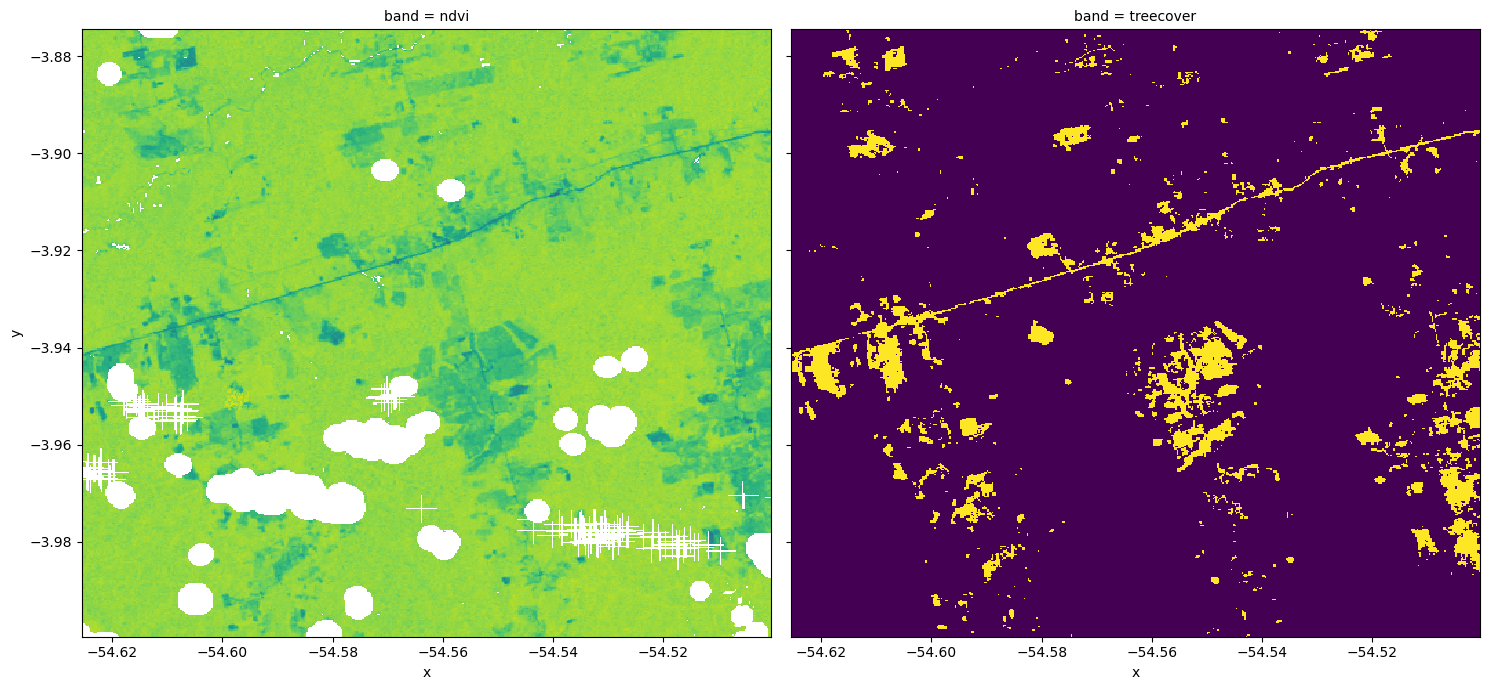

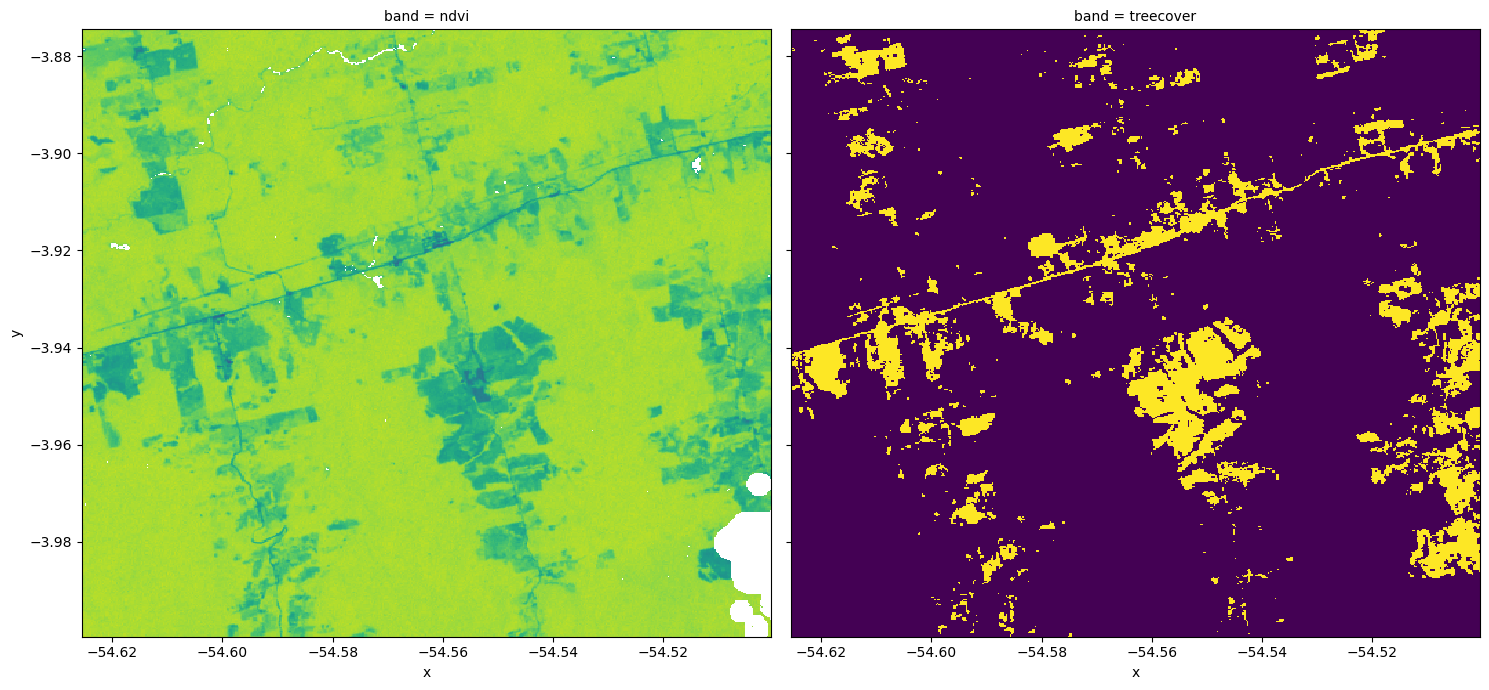

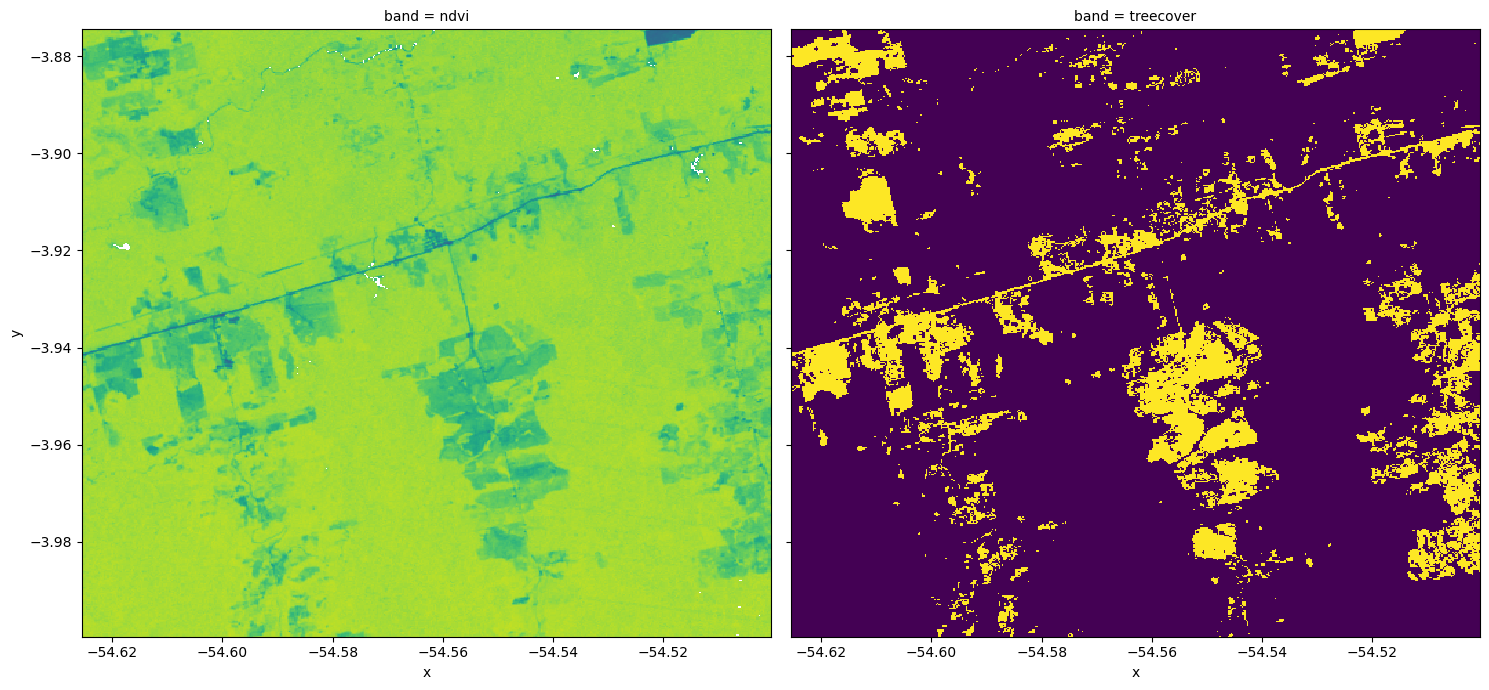

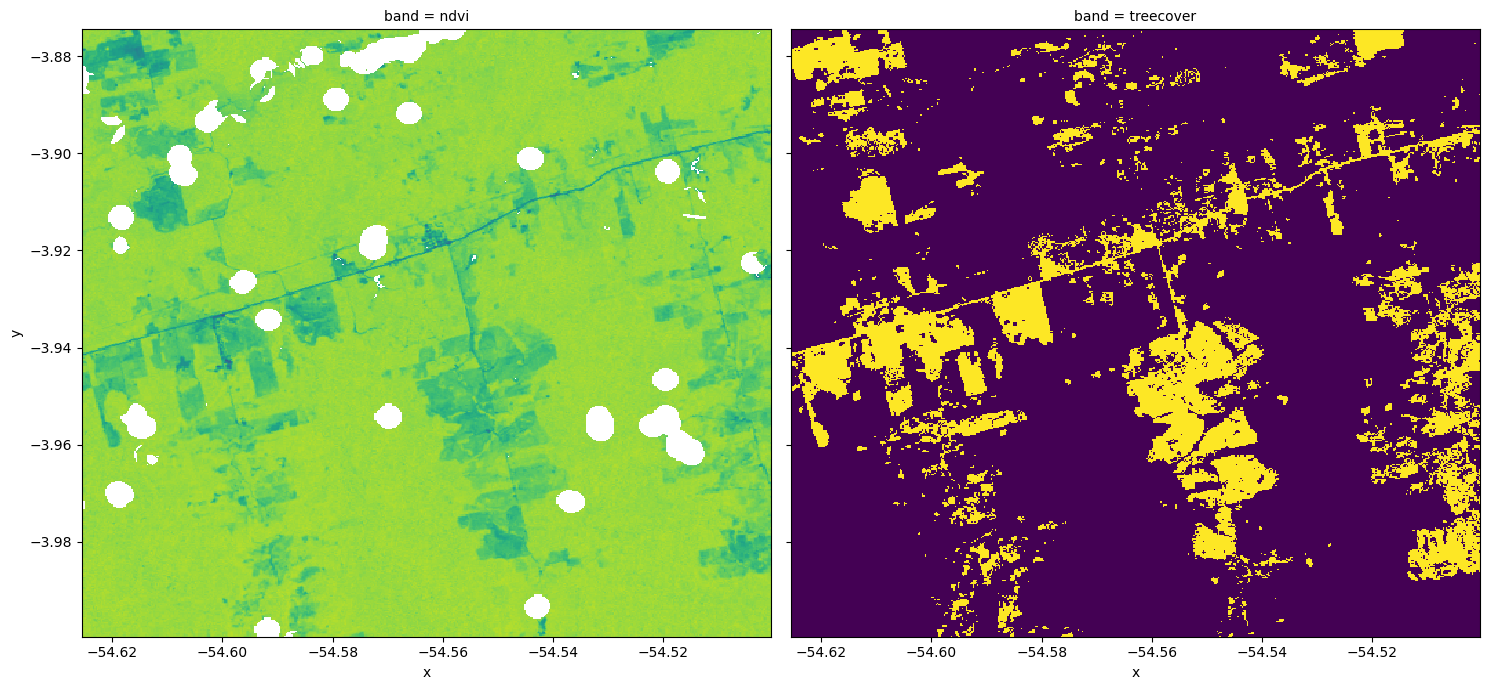

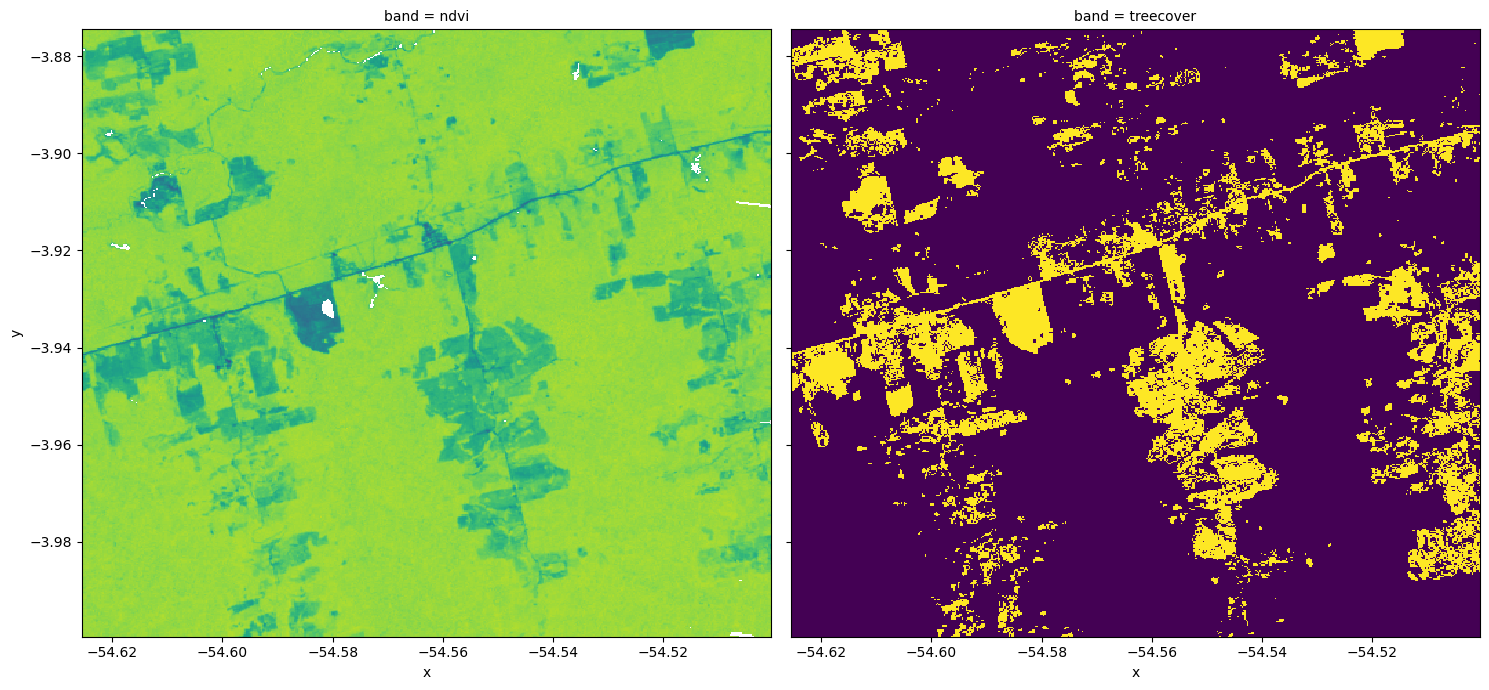

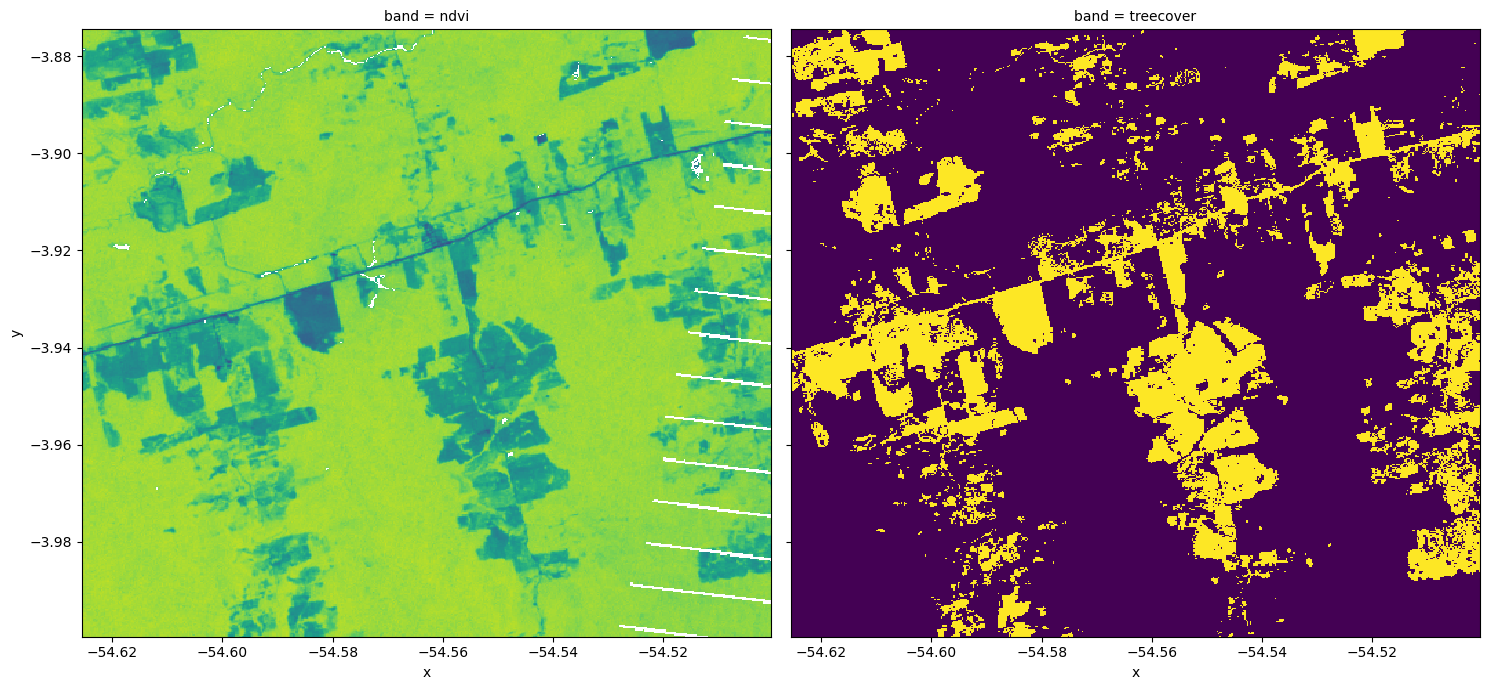

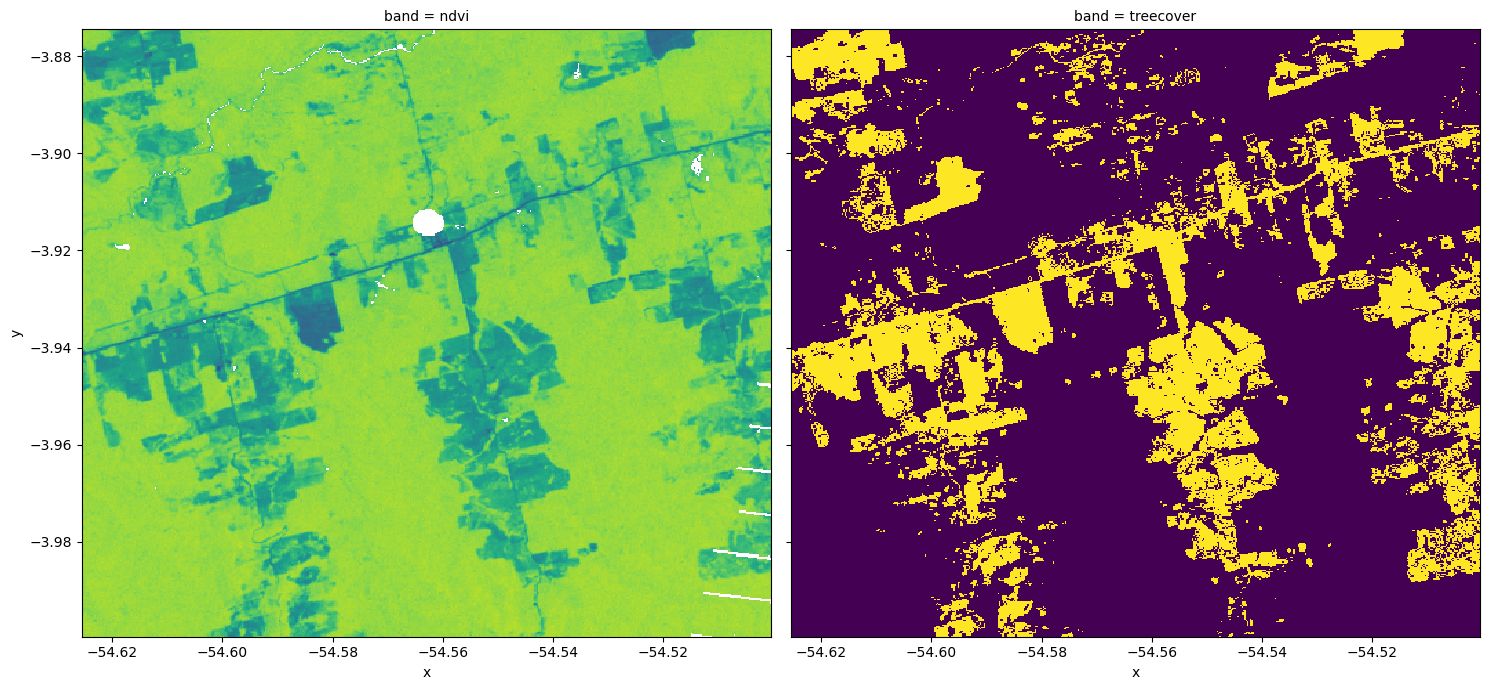

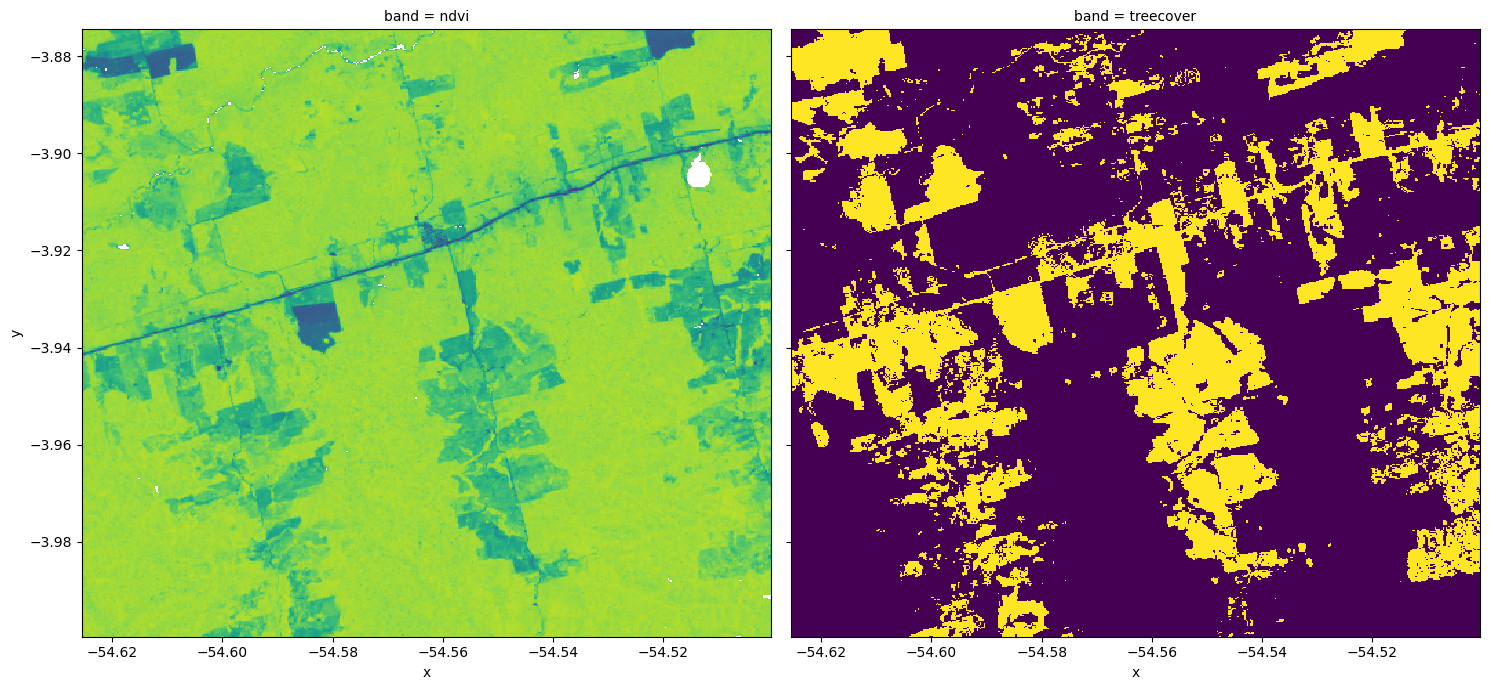

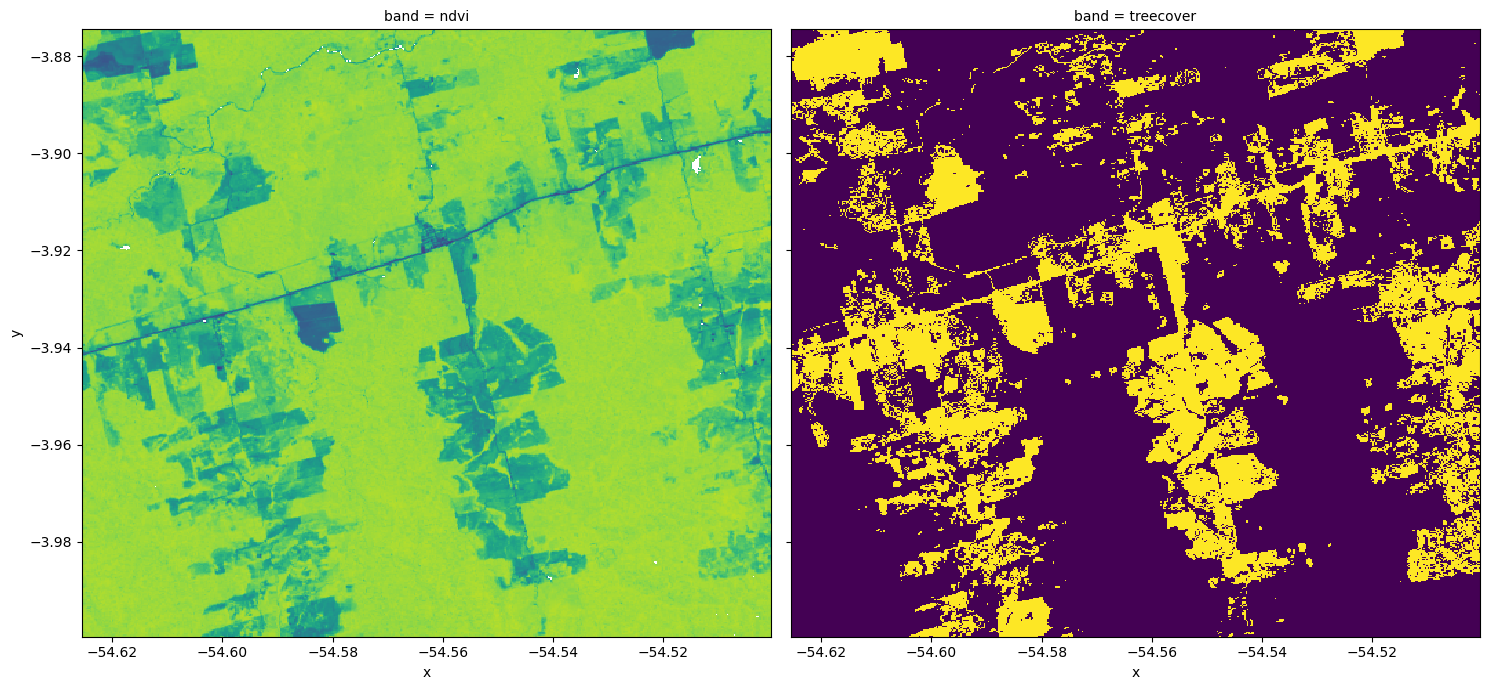

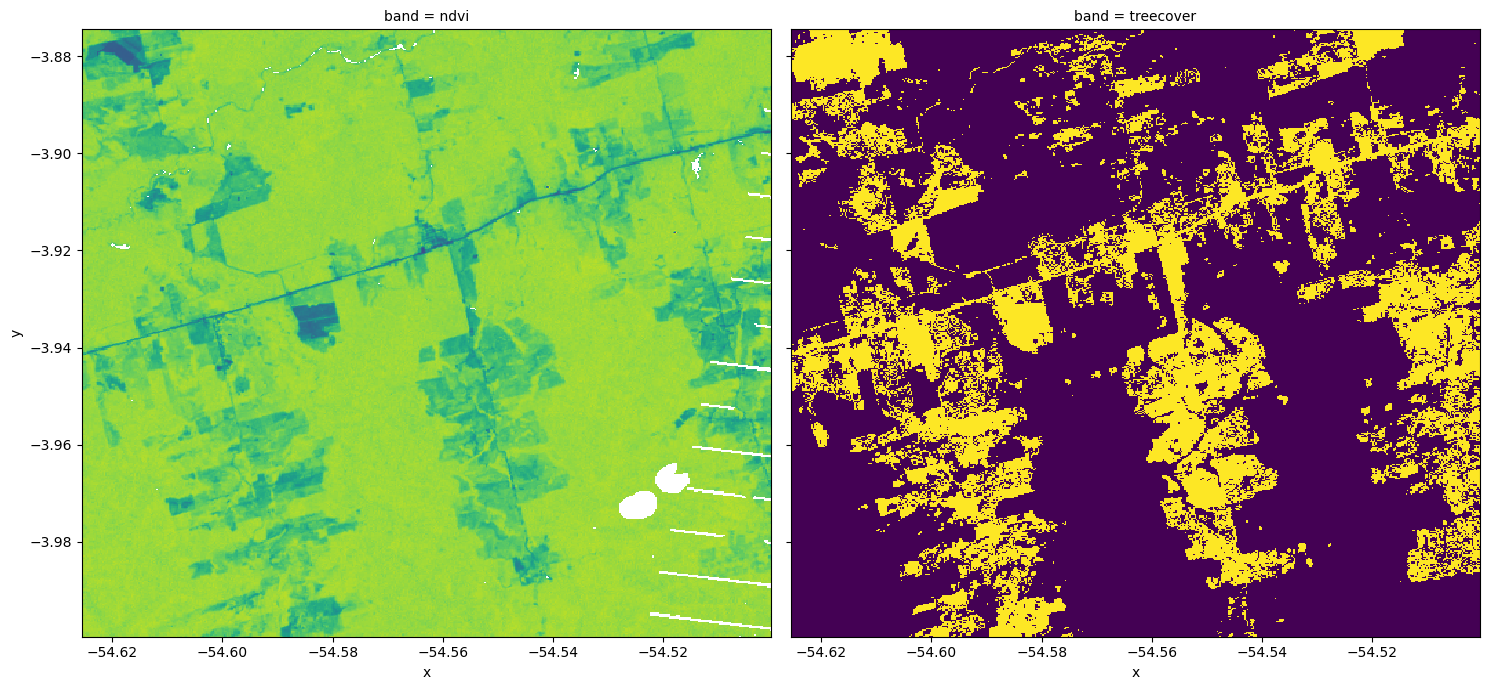

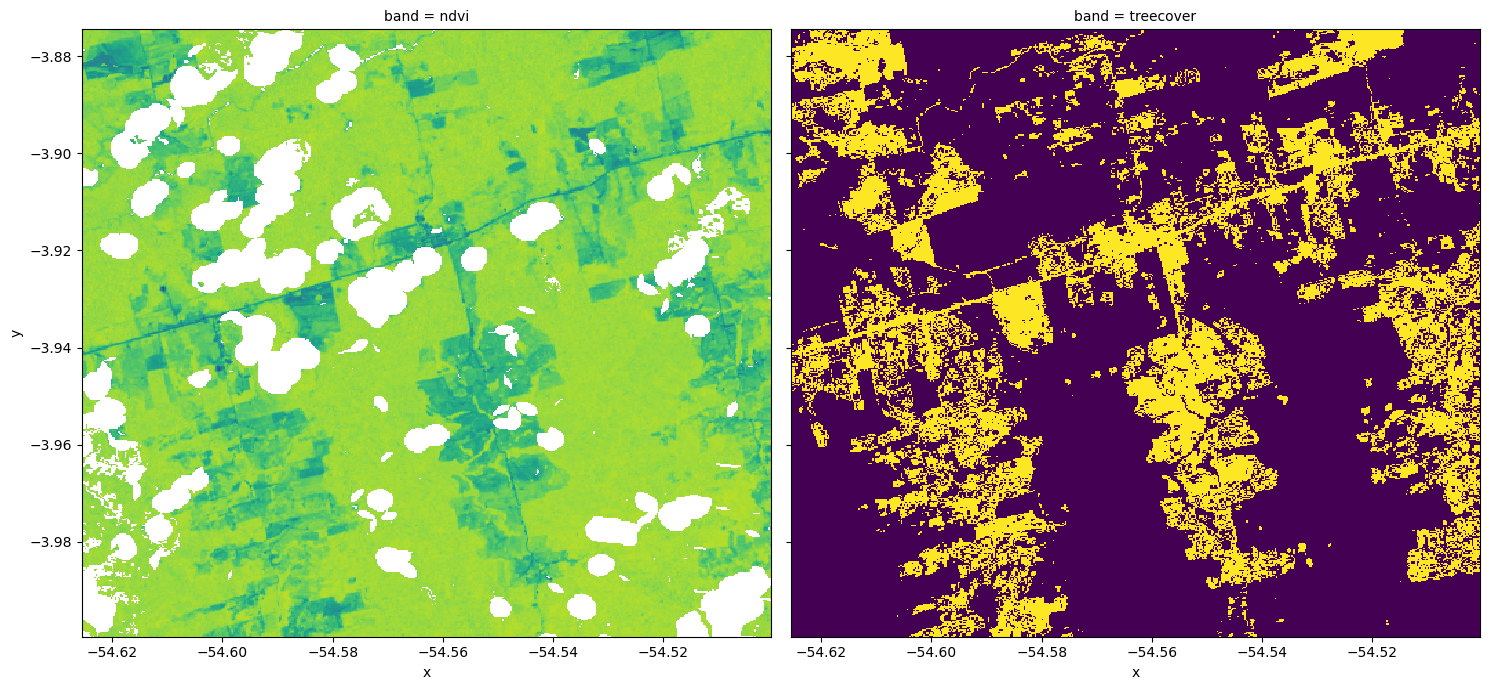

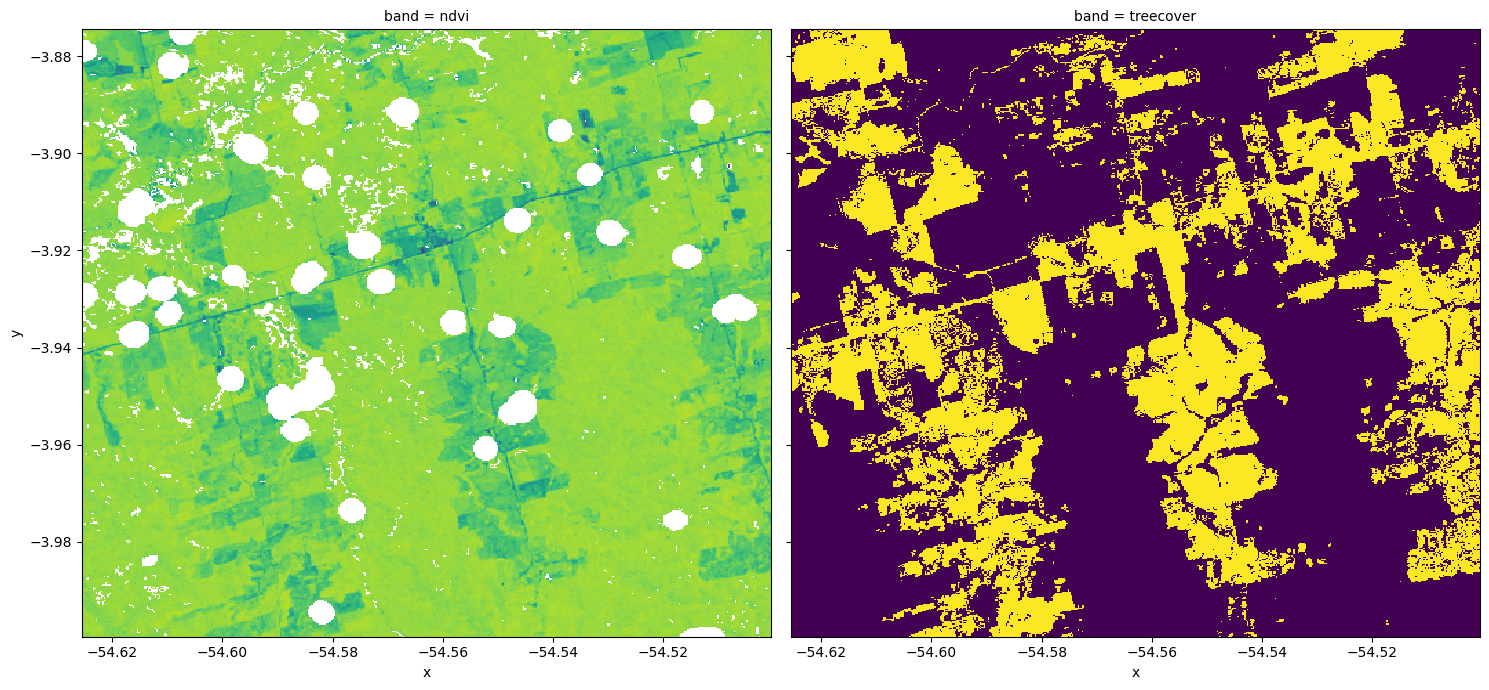

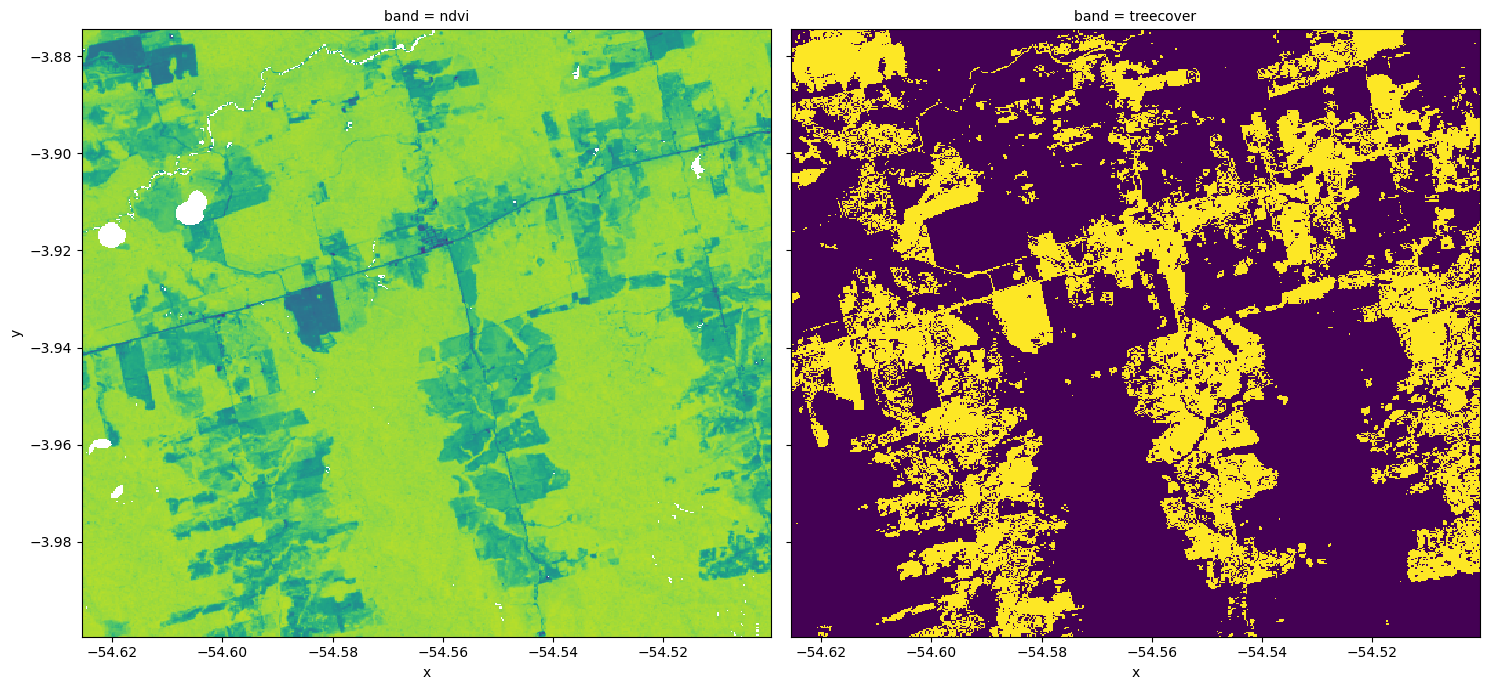

In [7]:
for i in range(0, len(stack['index']), 5):
  xr_plot = xr.concat([
    stack.isel(index=i)['band_data'],
    filled.isel(index=i)['band_data']
  ], dim='band')
  xr_plot['band'] = ['ndvi', 'treecover']
  xr_plot.plot(col='band', size=7, add_colorbar=False)
  plt.show()